In [47]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

pd.set_option('display.max_columns', 100)

import psycopg2

# 1. DataLoad

In [3]:
conn = psycopg2.connect("host=15.165.18.39 port=5432 user=linkshops password=$dpdlvmflf4 dbname=LINKSHOPS-20211121")

curs = conn.cursor()

In [3]:
#SQL = "SELECT * FROM ( SELECT ROW_NUMBER () OVER (ORDER BY 'id'), * FROM brands) x WHERE ROW_NUMBER BETWEEN 1 AND 30;"

In [5]:
SQL = "SELECT * FROM tb_credit_linkshops_order_products"

In [6]:
curs.execute(SQL)

In [7]:
dataframe = pd.DataFrame(curs)

In [9]:
SQL = "SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'tb_credit_linkshops_order_products'"

In [10]:
curs.execute(SQL)

In [11]:
dataframe.columns = [i[0] for i in curs]

In [12]:
dataframe

id                       created_at  creator_id  \
0        84662 2019-06-03 21:44:13.064588+00:00          44   
1        97328 2019-07-04 22:07:32.247916+00:00         124   
2       132682 2019-10-13 21:52:09.257259+00:00          44   
3        84655 2019-06-03 21:44:13.064588+00:00          44   
4        84665 2019-06-03 21:44:13.064588+00:00          44   
...        ...                              ...         ...   
233959  235153 2021-11-18 21:30:45.173048+00:00          44   
233960  234918 2021-11-16 21:12:39.655984+00:00          44   
233961  234792 2021-11-15 21:48:05.522708+00:00          44   
233962  234793 2021-11-15 21:48:05.522708+00:00          44   
233963  235156 2021-11-19 17:49:17.180219+00:00         215   

                             updated_at  updater_id use_yn  type  buyer_type  \
0      2019-06-04 06:02:22.559170+00:00          44      Y   610         200   
1      2019-07-24 00:48:26.123611+00:00         129      Y   610         200   
2      2019-10-14 07:58:17.793245+00:00         149      Y   610         200   
3      2019-06-04 06:02:22.559170+00:00          44      Y   610         200   
4      2019-06-04 06:02:22.559170+00:00          44      Y   610         200   
...                                 ...         ...    ...   ...         ...   
233959 2021-11-19 07:50:34.538560+00:00         194      Y   610         100   
233960 2021-11-19 08:07:26.498422+00:00         194      Y   610         200   
233961 2021-11-19 08:07:26.498422+00:00         194      Y   610         200   
233962 2021-11-19 08:07:26.498422+00:00         194      Y   610         200   
233963 2021-11-19 17:49:17.180219+00:00         215      Y   610         200   

        buyer_id  brand_id  ...  used_credit  status                 memo  \
0           8489      8233  ...      9000.00     400                 불량반품   
1          35811     14478  ...      7000.00     400                   반품   
2           8489      6347  ...     22000.00     400                 불량반품   
3           8489     12051  ...      9000.00     400                 불량반품   
4           8489     12123  ...     29000.00     400                 불량반품   
...          ...       ...  ...          ...     ...                  ...   
233959    138543     15147  ...     27000.00     400          [반품] 매장협의완료   
233960     88487     16269  ...     52000.00     400                 불량반품   
233961     88487     18088  ...     10000.00     400                 불량반품   
233962     88487     18088  ...     10000.00     400                 불량반품   
233963     88487     15833  ...         0.00     200  사이즈교환\nL->M으로 사이즈교환   

       wait_shipment_status register_type  register_id uncle_memo  \
0                      None           200           44       None   
1                      None           200          124       None   
2                      None           200           44       None   
3                      None           200           44       None   
4                      None           200           44       None   
...                     ...           ...          ...        ...   
233959                 None           200           44       None   
233960                 None           200           44       None   
233961                 None           200           44       None   
233962                 None           200           44       None   
233963                 None           200          215       None   

        deleted_memo seller_approval_credit updater_type  
0               None                9000.00        100.0  
1               None                7000.00        100.0  
2               None               22000.00        100.0  
3               None                9000.00        100.0  
4               None               29000.00        100.0  
...              ...                    ...          ...  
233959          None               27000.00        100.0  
233960          None               52000.00        100.0  
233961   

# 2. EDA

## 1) 데이터 현황 파악

### (1) 결측값 여부 확인

In [14]:
dataframe.apply(lambda x : x.isna().value_counts()).T

False      True
id                      233964.0       NaN
created_at              233964.0       NaN
creator_id              233964.0       NaN
updated_at              233964.0       NaN
updater_id              233964.0       NaN
use_yn                  233964.0       NaN
type                    233964.0       NaN
buyer_type              233964.0       NaN
buyer_id                233964.0       NaN
brand_id                233964.0       NaN
order_id                233964.0       NaN
order_product_id        233964.0       NaN
order_product_extra_id  229780.0    4184.0
total_credit            233963.0       1.0
credit                  233964.0       NaN
quantity                233964.0       NaN
used_credit             233964.0       NaN
status                  233964.0       NaN
memo                    220133.0   13831.0
wait_shipment_status         NaN  233964.0
register_type           233964.0       NaN
register_id             233964.0       NaN
uncle_memo               14282.0  219682.0
deleted_memo             13335.0  220629.0
seller_approval_credit  216503.0   17461.0
updater_type            158496.0   75468.0

- order_product_extra_id, memo, wait_shipment_status, uncle_memo, deleted_memo, seller_approval_credit, updater_type에 결측값이 존재한다.


- memo, deleted_memo, uncle_memo는 유저가 옵션으로 입력하는 부분이라고 볼 수 있어 결측값이 있는것이 자연스럽다.


- wait_shipment_status는 전부 결측값이므로 고려할 필요 없이 제외한다.


- order_product_extra_id는 order_product 테이블에서 이미 결측값이 생성된 상태이므로 분석에서 제외한다.


- seller_approval_credit, updater_type은 결측값이 있는 사례는 무엇인지 확인이 필요하다.



In [15]:
dataframe.describe()

id     creator_id     updater_id           type  \
count  233964.000000  233964.000000  233964.000000  233964.000000   
mean   117783.008241    2605.476719    3445.539421     610.016242   
std     67949.659774   12465.583745   14027.769453       0.402685   
min         1.000000       2.000000       1.000000     610.000000   
25%     58666.750000      44.000000      44.000000     610.000000   
50%    118097.500000      44.000000     129.000000     610.000000   
75%    176665.250000     122.000000     148.000000     610.000000   
max    235156.000000   88487.000000   88487.000000     620.000000   

          buyer_type       buyer_id       brand_id      order_id  \
count  233964.000000  233964.000000  233964.000000  2.339640e+05   
mean      196.870031   54587.228501    9358.684558  5.337238e+05   
std        17.412681   20785.820041    3845.402304  2.630898e+05   
min       100.000000    1183.000000      28.000000  1.028210e+05   
25%       200.000000   35811.000000    6283.000000  3.435090e+05   
50%       200.000000   52048.000000    9726.000000  4.642930e+05   
75%       200.000000   68576.000000   12062.000000  7.198220e+05   
max       200.000000  147420.000000   18607.000000  1.174315e+06   

       order_product_id  order_product_extra_id       quantity         status  \
count      2.339640e+05           229780.000000  233964.000000  233964.000000   
mean       8.338094e+06           371992.625115       3.550003     407.593049   
std        3.609764e+06           196120.724151     170.884768     154.760459   
min        1.532797e+06            22871.000000       0.000000       0.000000   
25%        5.550956e+06           205547.750000       1.000000     400.000000   
50%        7.792178e+06           353830.500000       1.000000     400.000000   
75%        1.118048e+07           559397.250000       1.000000     400.000000   
max        1.598671e+07           695401.000000   35000.000000     900.000000   

       register_type    register_id   updater_type  
count  233964.000000  233964.000000  158496.000000  
mean      198.901113    2605.476813     123.589239  
std        30.993728   12465.583725      55.010162  
min       100.000000       2.000000     100.000000  
25%       200.000000      44.000000     100.000000  
50%       200.000000      44.000000     100.000000  
75%       200.000000     122.000000     100.000000  
max       400.000000   88487.000000     300.000000

In [16]:
dataframe.buyer_type.unique()

array([200, 100], dtype=int64)

In [17]:
dataframe.status.unique()

array([400, 900, 200, 300,   0, 100], dtype=int64)

- 100 : 차감대기
- 200 : 차감승인
- 300 : 부분차감
- 400 : 차감완료

- 900은 tb_credit_buyer_log 테이블과 동일하다면 '매입금 삭제'의 코드일 것으로 추정

0은 확인이 필요하다.

In [18]:
dataframe.register_type.unique()

array([200, 100, 300, 400], dtype=int64)

- 100 : 어드민
- 200 : 삼촌

300, 400은 확인이 필요하다.

In [19]:
dataframe.updater_type.unique()

array([100., 300., 200.,  nan])

- 100 : 어드민
- 200 : 삼촌
- 300 : 유저

값이 없는 경우는 확인이 필요하다.

## 2) status 기반 분석

### (1) status 변수 현황

In [22]:
dataframe['status'].value_counts()

400    182890
200     33564
900     17074
300       416
100        19
0           1
Name: status, dtype: int64

- 200 : 차감승인
- 300 : 부분차감
- 400 : 차감완료
- 100 : 차감대기
- 900 : 매입금 삭제

### (2) status의 흐름

#### - 가설2 : status의 흐름을 결정짓는것은 order_id일 것이다.

In [244]:
chain_order = dataframe.sort_values(['order_id','created_at']).groupby('order_id')['status'].apply(
    lambda x : '-'.join(np.array(list(x)).astype('str')))

In [245]:
len(dataframe['order_id'].unique())

18302

In [246]:
len(dataframe['order_product_id'].unique())

199228

unique를 한 경우, order_product_id쪽이 갯수가 더 많다.

In [247]:
chain_order

order_id
102821                                                   200
103530                                               200-400
103929                                                   200
113107                                                   200
113474                                               200-300
                                 ...                        
1173324                                                  200
1173464    200-200-200-200-200-200-200-200-200-200-200-20...
1173499                              200-200-200-200-200-200
1173737    200-200-200-200-200-200-200-200-200-200-200-20...
1174315                                                  200
Name: status, Length: 18302, dtype: object

In [248]:
chain_order.value_counts()

400                                                                                                                                                                                                                                                                                                                5395
400-400                                                                                                                                                                                                                                                                                                            1561
400-400-400                                                                                                                                                                                                                                                                                                         744
400-400-400-400                                                 

In [249]:
chain_order.value_counts().describe()

count    4483.000000
mean        4.082534
std        85.789854
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      5395.000000
Name: status, dtype: float64

In [250]:
(chain_order.value_counts() - np.min(chain_order.value_counts())) / (
    np.max(chain_order.value_counts()) - np.min(chain_order.value_counts()))

400                                                                                                                                                                                                                                                                                                                1.000000
400-400                                                                                                                                                                                                                                                                                                            0.289210
400-400-400                                                                                                                                                                                                                                                                                                        0.137746
400-400-400-400                                     

In [251]:
chain_product = dataframe.sort_values(['order_product_id','created_at']).groupby(
    'order_product_id')['status'].apply(
    lambda x : '-'.join(np.array(list(x)).astype('str')))

In [252]:
chain_product

order_product_id
1532797         200
1550792     200-400
1556721         200
1740000         200
1745567         200
             ...   
15981389        200
15981390        200
15981391        200
15981392        200
15986706        200
Name: status, Length: 199228, dtype: object

In [240]:
(chain_product.value_counts() - np.min(chain_product.value_counts())) / (
    np.max(chain_product.value_counts()) - np.min(chain_product.value_counts()))

400                                1.000000
200-400                            0.072595
200                                0.065775
900-400                            0.052716
900                                0.021118
                                     ...   
200-200-200-200-200-900-900-400    0.000000
200-200-400-200-400                0.000000
200-200-200-200-400-200            0.000000
200-400-900-400                    0.000000
900-900-200-200                    0.000000
Name: status, Length: 160, dtype: float64

In [241]:
chain_product.value_counts().describe()

count       160.00000
mean       1245.17500
std       12566.51324
min           1.00000
25%           1.00000
50%           2.00000
75%           9.25000
max      158207.00000
Name: status, dtype: float64

In [253]:
len(chain_order.value_counts()) / len(chain_order)

0.2449459075510873

In [254]:
len(chain_product.value_counts()) / len(chain_product)

0.0008030999658682514

가짓수 / 총 갯수의 비율을 구한 결과, product쪽이 값이 더 작다

결론 : order_product_id별로 경로를 구한다.

In [263]:
chain_product = dataframe[dataframe['use_yn'] == 'Y'].sort_values(['order_product_id','created_at']).groupby(
    'order_product_id')['status'].apply(
    lambda x : '-'.join(np.array(list(x)).astype('str')))

In [265]:
chain_product

order_product_id
1550792     400
1745631     300
1986531     900
1991571     200
2004333     400
           ... 
15981389    200
15981390    200
15981391    200
15981392    200
15986706    200
Name: status, Length: 190635, dtype: object

In [256]:
dataframe[dataframe['order_product_id'] == 1550792]

id                       created_at  creator_id  \
74594  12795 2018-08-19 21:20:25.706221+00:00          44   
74850  12637 2018-08-16 21:26:23.828476+00:00          44   

                            updated_at  updater_id use_yn  type  buyer_type  \
74594 2018-08-20 16:09:40.529077+00:00          44      Y   610         200   
74850 2018-08-16 21:26:23.828476+00:00          44      N   610         200   

       buyer_id  brand_id  order_id  order_product_id  order_product_extra_id  \
74594     34500      8843    103530           1550792                 69223.0   
74850     34500      8843    103530           1550792                 69223.0   

      total_credit    credit  quantity used_credit  status  memo  \
74594     39000.00  13000.00         3    39000.00     400  불량반품   
74850     39000.00  13000.00         3        0.00     200  불량반품   

      wait_shipment_status  register_type  register_id uncle_memo  \
74594                 None            200           44       None   
74850                 None            200           44       None   

      deleted_memo seller_approval_credit  updater_type deriv_credit  
74594         None               39000.00           NaN     26000.00  
74850         None                   0.00           NaN     26000.00

### (3) seller_approval_credit

#### - seller_approval_credit이 결측인 경우

- seller_approval_credit이 결측인 경우에 대한 탐색을 진행한다.

가설 3 : seller_approval_credit이 결측인 경우 status가 300, 400 이외의 값일것이다.

In [96]:
dataframe.loc[dataframe['seller_approval_credit'].isna(), 'status'].value_counts()

200    10094
900     7365
400        2
Name: status, dtype: int64

가설이 어느정도 들어맞았지만, '완전 차감'임에도 seller_approval_credit이 결측이 사례가 두건 있다.

확인이 필요하다.

In [99]:
dataframe.loc[(dataframe['seller_approval_credit'].isna()) & (
                dataframe['status'] == 400),]

id                       created_at  creator_id  \
18137    76053 2019-05-15 21:50:41.470907+00:00          44   
223035  222287 2021-05-24 21:00:21.949896+00:00          44   

                             updated_at  updater_id use_yn  type  buyer_type  \
18137  2019-05-15 21:50:41.470907+00:00          44      Y   610         200   
223035 2021-05-25 00:44:07.008078+00:00         130      Y   610         200   

        buyer_id  brand_id  order_id  order_product_id  \
18137      61027      8792    378700           6199568   
223035     22020      7869   1022163          14520990   

        order_product_extra_id total_credit  credit  quantity used_credit  \
18137                 248041.0       700.00  700.00         1      700.00   
223035                668538.0         0.00    1.00         2        0.00   

        status   memo wait_shipment_status  register_type  register_id  \
18137      400     반품                 None            200           44   
223035     400  오입고반품                 None            200           44   

       uncle_memo       deleted_memo seller_approval_credit  updater_type  \
18137        None               None                   None         200.0   
223035             2864 외부매입으로 생성된건임                   None         100.0   

       deriv_credit  
18137          0.00  
223035        -1.00

- 첫 번째 사례는 삼촌(register_type = 200, updater_type = 200)이 입력한 사례로, 손실수로 보인다.

- 두 번째는 입력은 삼촌(register_type = 200)이 했으나, 수정은 직원(updater_type = 100)이 진행했다. 

In [101]:
dataframe[dataframe['order_id'] == 1022163]

id                       created_at  creator_id  \
223006  222100 2021-05-24 20:48:00.446815+00:00          44   
223031  222120 2021-05-24 20:48:00.446815+00:00          44   
223035  222287 2021-05-24 21:00:21.949896+00:00          44   
230576  222267 2021-05-24 21:00:21.949896+00:00          44   

                             updated_at  updater_id use_yn  type  buyer_type  \
223006 2021-05-24 21:00:21.949896+00:00          44      N   610         200   
223031 2021-05-24 21:00:21.949896+00:00          44      N   610         200   
223035 2021-05-25 00:44:07.008078+00:00         130      Y   610         200   
230576 2021-10-18 08:02:53.005964+00:00         194      Y   610         200   

        buyer_id  brand_id  order_id  order_product_id  \
223006     22020      6198   1022163          14520989   
223031     22020      7869   1022163          14520990   
223035     22020      7869   1022163          14520990   
230576     22020      6198   1022163          14520989   

        order_product_extra_id total_credit    credit  quantity used_credit  \
223006                668537.0     16000.00  16000.00         1        0.00   
223031                668538.0         2.00      1.00         2        0.00   
223035                668538.0         0.00      1.00         2        0.00   
230576                668537.0     16000.00  16000.00         1    16000.00   

        status   memo wait_shipment_status  register_type  register_id  \
223006     200   불량반품                 None            200           44   
223031     200  오입고반품                 None            200           44   
223035     400  오입고반품                 None            200           44   
230576     400   불량반품                 None            200           44   

       uncle_memo       deleted_memo seller_approval_credit  updater_type  \
223006       None               None                   None         200.0   
223031                          None                   None         200.0   
223035             2864 외부매입으로 생성된건임                   None         100.0   
230576       None               None               16000.00         100.0   

       deriv_credit  
223006         0.00  
223031         1.00  
223035        -1.00  
230576         0.00

 - 메모가 '오입고 반품'인 것으로 보아, 과입고 된 사례를 다시 셀러에게 반송한 사례로 보인다. 해당 사례는 매입금으로 처리하면 안됐으나, 매입금으로 처리되었고 내부적으로 처리할 때 '매입금 삭제'가 아닌 '완전 차감'으로 처리된것으로 보인다.

In [107]:
dataframe[dataframe['updater_type'].isna()]

id                       created_at  creator_id  \
16        7320 2018-07-06 06:17:11.429306+00:00          43   
104      81702 2019-05-27 05:59:43.171719+00:00          62   
105      81707 2019-05-27 06:00:06.480871+00:00          62   
162      55420 2019-03-26 21:30:48.897098+00:00          44   
163      63507 2019-04-16 21:53:32.131250+00:00          44   
...        ...                              ...         ...   
229854  231140 2021-09-15 04:27:59.746406+00:00         115   
231571  232818 2021-10-27 05:13:41.945865+00:00         181   
232814  234136 2021-11-05 02:35:31.225126+00:00         191   
233282  234528 2021-11-11 06:49:49.097049+00:00         193   
233283  234529 2021-11-11 06:50:30.274481+00:00         193   

                             updated_at  updater_id use_yn  type  buyer_type  \
16     2018-07-10 08:50:11.789080+00:00          43      Y   610         200   
104    2019-05-27 05:59:43.171719+00:00          62      Y   610         200   
105    2019-05-27 06:00:06.480871+00:00          62      Y   610         200   
162    2019-05-21 00:59:09.415446+00:00          44      Y   610         200   
163    2019-05-21 00:59:09.415446+00:00          44      Y   610         200   
...                                 ...         ...    ...   ...         ...   
229854 2021-09-15 04:28:09.503726+00:00         115      Y   610         200   
231571 2021-10-27 05:14:08.557954+00:00         181      Y   610         200   
232814 2021-11-05 02:35:39.092904+00:00         191      Y   610         200   
233282 2021-11-11 06:50:32.843117+00:00         193      Y   610         200   
233283 2021-11-11 06:50:35.745035+00:00         193      Y   610         200   

        buyer_id  brand_id  order_id  order_product_id  \
16         34559      6315    159785           2692815   
104        67545      6398    390433           6418967   
105        67545      6398    390433           6418962   
162        22347     13999    341171           5511600   
163        22347     13999    358420           5818128   
...          ...       ...       ...               ...   
229854     79016      7890    943224          13643080   
231571     34500     16814   1136761          15642213   
232814     79016     13251   1160487          15854814   
233282     52048     16241   1088647          15191665   
233283     52048     16241   1166725          15911783   

        order_product_extra_id total_credit    credit  quantity used_credit  \
16                     61414.0     27000.00  27000.00         1    27000.00   
104                   260798.0     22000.00  22000.00         1        0.00   
105                   260793.0     22000.00  22000.00         1        0.00   
162                   201330.0     20000.00  10000.00         2    20000.00   
163                   222264.0     10000.00  10000.00         1    10000.00   
...                        ...          ...       ...       ...         ...   
229854                643362.0      7000.00   7000.00         1        0.00   
231571                690995.0      9000.00   9000.00         1        0.00   
232814                693507.0     32000.00  32000.00         1        0.00   
233282                683372.0     43000.00  43000.00         1        0.00   
233283                694464.0     17000.00  17000.00         1        0.00   

        status  memo wait_shipment_status  register_type  register_id  \
16         400  None                 None            100           43   
104        200  None                 None            100           62   
105        200  None                 None            100           62   
162        400  불량반품                 None            200           44   
163        400  불량반품                 None            200           44   
...        ...   ...                  ...            ...          ...   
229854     900  None                 None            100          115   
231571     900  None                 None            100        

#### 결론 : seller_approval_credit이 결측값인 경우 '차감 승인'이나 '매입금 삭제'였다. 일부(2건) 그렇지 않은 사례는 입력 실수인것으로 보인다.

#### - status별 seller_approval_credit과 total_credit의 차이

가설 3 : status가 400인 경우, total_credit에서 seller_approval_credit을 뺀 금액은 0일것이다.

In [274]:
(dataframe.loc[dataframe['status'] == 400, 'total_credit'] - (
    dataframe.loc[dataframe['status'] == 400, 'seller_approval_credit'])).dropna().astype('int').describe()

count    182887.000000
mean          7.588768
std        1177.927331
min     -158638.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      299000.000000
dtype: float64

In [281]:
dataframe['deriv_credit_seller'] = (dataframe.loc[dataframe['status'] == 400, 'total_credit'] - (
    dataframe.loc[dataframe['status'] == 400, 'seller_approval_credit'])).dropna().astype('int')

In [300]:
dataframe_dropna = dataframe.dropna(axis = 0, 
                 subset = ['deriv_credit_seller'])

In [310]:
dataframe_dropna[(dataframe_dropna['deriv_credit_seller'] > 0) & (
    dataframe_dropna['buyer_type'] == 100)]

id                       created_at  creator_id  \
94830  24187 2018-11-02 08:16:12.561072+00:00          62   

                            updated_at  updater_id use_yn  type  buyer_type  \
94830 2018-11-05 08:26:54.216991+00:00          62      Y   610         100   

       buyer_id  brand_id  order_id  order_product_id  order_product_extra_id  \
94830     54654     12165    234796           3912972                     NaN   

      total_credit    credit  quantity used_credit  status  memo  \
94830     52000.00  52000.00         1    28000.00     400  단가변경   

      wait_shipment_status  register_type  register_id uncle_memo  \
94830                 None            100           62       None   

      deleted_memo seller_approval_credit  updater_type deriv_credit  \
94830         None               28000.00           NaN         0.00   

       deriv_credit_seller  
94830              24000.0

In [304]:
dataframe_dropna[dataframe_dropna['deriv_credit_seller'] <= 0]

id                       created_at  creator_id  \
0        84662 2019-06-03 21:44:13.064588+00:00          44   
1        97328 2019-07-04 22:07:32.247916+00:00         124   
2       132682 2019-10-13 21:52:09.257259+00:00          44   
3        84655 2019-06-03 21:44:13.064588+00:00          44   
4        84665 2019-06-03 21:44:13.064588+00:00          44   
...        ...                              ...         ...   
233958  235149 2021-11-18 21:16:54.667770+00:00          44   
233959  235153 2021-11-18 21:30:45.173048+00:00          44   
233960  234918 2021-11-16 21:12:39.655984+00:00          44   
233961  234792 2021-11-15 21:48:05.522708+00:00          44   
233962  234793 2021-11-15 21:48:05.522708+00:00          44   

                             updated_at  updater_id use_yn  type  buyer_type  \
0      2019-06-04 06:02:22.559170+00:00          44      Y   610         200   
1      2019-07-24 00:48:26.123611+00:00         129      Y   610         200   
2      2019-10-14 07:58:17.793245+00:00         149      Y   610         200   
3      2019-06-04 06:02:22.559170+00:00          44      Y   610         200   
4      2019-06-04 06:02:22.559170+00:00          44      Y   610         200   
...                                 ...         ...    ...   ...         ...   
233958 2021-11-19 07:47:08.966942+00:00         194      Y   610         200   
233959 2021-11-19 07:50:34.538560+00:00         194      Y   610         100   
233960 2021-11-19 08:07:26.498422+00:00         194      Y   610         200   
233961 2021-11-19 08:07:26.498422+00:00         194      Y   610         200   
233962 2021-11-19 08:07:26.498422+00:00         194      Y   610         200   

        buyer_id  brand_id  order_id  order_product_id  \
0           8489      8233    398626           6568026   
1          35811     14478    428093           7111659   
2           8489      6347    503013           8427250   
3           8489     12051    398626           6568023   
4           8489     12123    398626           6568032   
...          ...       ...       ...               ...   
233958     22020     14025   1166735          15911966   
233959    138543     15147   1154328          15795299   
233960     88487     16269   1171341          15959862   
233961     88487     18088   1168955          15936326   
233962     88487     18088   1168955          15936325   

        order_product_extra_id total_credit    credit  quantity used_credit  \
0                     270425.0      9000.00   9000.00         1     9000.00   
1                     300602.0      7000.00   7000.00         1     7000.00   
2                     400381.0     22000.00  22000.00         1    22000.00   
3                     270422.0      9000.00   9000.00         1     9000.00   
4                     270431.0     29000.00  29000.00         1    29000.00   
...                        ...          ...       ...       ...         ...   
233958                694565.0      3500.00   3500.00         1     3500.00   
233959                694545.0     27000.00  27000.00         1    27000.00   
233960                694885.0     52000.00  26000.00         2    52000.00   
233961                694664.0     10000.00  10000.00         1    10000.00   
233962                694663.0     10000.00  10000.00         1    10000.00   

        status         memo wait_shipment_status  register_type  register_id  \
0          400         불량반품                 None            200           44   
1          400           반품                 None            200          124   
2          400         불량반품                 None            200           44   
3          400         불량반품                 None            200           44   
4          400         불량반품                 None            200           44   
...        ...          ...                  ...            ...          ...   
233958     400        색상오배송                 None            200           44   
233959  

In [320]:
def credit_balancer(x):
    tot_200 = x.loc[x['status'] == 200, ['total_credit', 'seller_approval_credit']]
    tot_300 = x.loc[x['status'] == 300, ['total_credit', 'seller_approval_credit']]
    tot_400 = x.loc[x['status'] == 400, ['total_credit', 'seller_approval_credit']]
    
    return np.sum(tot_200), np.sum(tot_300), np.sum(tot_400)

In [321]:
credit_balancer(dataframe[dataframe['order_product_id'] == 8427250])

(total_credit              0.0
 seller_approval_credit    0.0
 dtype: float64,
 total_credit              0.0
 seller_approval_credit    0.0
 dtype: float64,
 total_credit              22000.00
 seller_approval_credit    22000.00
 dtype: object)

In [319]:
dataframe[dataframe['order_product_id'] == 15959862]

id                       created_at  creator_id  \
233960  234918 2021-11-16 21:12:39.655984+00:00          44   

                             updated_at  updater_id use_yn  type  buyer_type  \
233960 2021-11-19 08:07:26.498422+00:00         194      Y   610         200   

        buyer_id  brand_id  order_id  order_product_id  \
233960     88487     16269   1171341          15959862   

        order_product_extra_id total_credit    credit  quantity used_credit  \
233960                694885.0     52000.00  26000.00         2    52000.00   

        status  memo wait_shipment_status  register_type  register_id  \
233960     400  불량반품                 None            200           44   

       uncle_memo deleted_memo seller_approval_credit  updater_type  \
233960       None         None               52000.00         100.0   

       deriv_credit  deriv_credit_seller  
233960     26000.00                  0.0

In [324]:
dataframe.loc[dataframe['status'] == 300, ['order_product_id','total_credit', 'seller_approval_credit']]

order_product_id total_credit seller_approval_credit
1077             2760526     70000.00               70000.00
1863             5771414     29000.00               26000.00
3441             6126790     24000.00                6000.00
3756             4940976     20000.00               10000.00
4643             5348708    221000.00               60000.00
...                  ...          ...                    ...
233626          15923473     20000.00               10000.00
233658          15959941     34000.00               30000.00
233660          15530070     45900.00               20000.00
233786          15936310     32000.00               31000.00
233941          15978084     22000.00               17000.00

[416 rows x 3 columns]

In [327]:
dataframe[dataframe['order_product_id'] == 15936310]

id                       created_at  creator_id  \
233530  234725 2021-11-15 21:02:47.372550+00:00          44   
233786  234831 2021-11-15 21:48:05.522708+00:00          44   

                             updated_at  updater_id use_yn  type  buyer_type  \
233530 2021-11-15 21:48:05.522708+00:00          44      N   610         200   
233786 2021-11-18 08:04:39.088004+00:00         194      Y   610         200   

        buyer_id  brand_id  order_id  order_product_id  \
233530     88487      9553   1168955          15936310   
233786     88487      9553   1168955          15936310   

        order_product_extra_id total_credit    credit  quantity used_credit  \
233530                694648.0     32000.00  32000.00         1        0.00   
233786                694648.0     32000.00  32000.00         1    31000.00   

        status  memo wait_shipment_status  register_type  register_id  \
233530     200  불량반품                 None            200           44   
233786     300  불량반품                 None            200           44   

       uncle_memo deleted_memo seller_approval_credit  updater_type  \
233530       None         None                   None         200.0   
233786       None         None               31000.00         100.0   

       deriv_credit  deriv_credit_seller  
233530         0.00                  NaN  
233786         0.00                  NaN

In [318]:
credit_balancer(dataframe[dataframe['order_product_id'] == 15959862])

(0, 0, Decimal('52000.00'))

In [307]:
dataframe.groupby('order_product_id').apply(lambda x : np.sum(x['']))

#### - status별 seller_approval_credit과 used_credit의 차이

가설 4: 모든 경우에서, seller_approval_credit = used_credit일 것이다.

In [341]:
dataframe['used_seller_credit'] = dataframe['seller_approval_credit'] - dataframe['used_credit']

In [342]:
dataframe['used_seller_credit'].sort_values().dropna().astype('int').describe()

count    2.165030e+05
mean     8.969731e+02
std      6.937352e+03
min     -9.000000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.105000e+06
Name: used_seller_credit, dtype: float64

<AxesSubplot:>

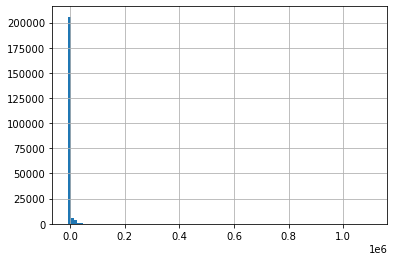

In [343]:
dataframe['used_seller_credit'].hist(bins = 100)

In [349]:
dataframe['status'].value_counts()

400    182890
200     33564
900     17074
300       416
100        19
0           1
Name: status, dtype: int64

In [348]:
dataframe.loc[dataframe['used_seller_credit'] > 0, 'status'].value_counts()

900    5601
200    5129
300      50
400       4
Name: status, dtype: int64

In [350]:
dataframe.loc[dataframe['used_seller_credit'] > 0, 'buyer_type'].value_counts()

200    10470
100      314
Name: buyer_type, dtype: int64

- seller_approval_credit과 used_credit 사이에 차이가 존재하는 경우는 대부분 '900', 혹은 '200'이었다.
- 또한, 압도적 다수는 200, 즉 빅바이어였다.

In [353]:
dataframe.loc[(dataframe['used_seller_credit'] > 0) & (dataframe['status'] == 200), 'buyer_type'].value_counts()

200    5044
100      85
Name: buyer_type, dtype: int64

In [355]:
dataframe.loc[(dataframe['used_seller_credit'] > 0) & (
    dataframe['status'] == 200) & (
    dataframe['buyer_type'] == 100), ]

id                       created_at  creator_id  \
1175     76022 2019-05-15 03:02:04.571753+00:00         136   
1176     76021 2019-05-15 02:51:40.209531+00:00         136   
1623     76049 2019-05-15 17:28:11.185070+00:00          98   
4113    101430 2019-07-12 06:15:32.764022+00:00         161   
10381   106044 2019-07-24 09:18:37.802351+00:00          99   
...        ...                              ...         ...   
232815  234135 2021-11-04 21:34:51.707707+00:00          44   
233305  234531 2021-11-11 05:10:04.078253+00:00          44   
233306  234533 2021-11-11 05:10:04.078253+00:00          44   
233401  234608 2021-11-12 08:55:03.640871+00:00          44   
233657  234897 2021-11-16 05:25:03.442985+00:00          44   

                             updated_at  updater_id use_yn  type  buyer_type  \
1175   2019-05-15 03:02:04.571753+00:00         136      N   610         100   
1176   2019-05-15 02:51:40.209531+00:00         136      N   610         100   
1623   2019-05-15 21:32:08.022670+00:00         122      N   610         100   
4113   2019-07-12 06:15:32.764022+00:00         161      Y   610         100   
10381  2019-07-24 09:18:37.802351+00:00          99      Y   610         100   
...                                 ...         ...    ...   ...         ...   
232815 2021-11-05 05:40:03.478230+00:00          44      Y   610         100   
233305 2021-11-19 04:00:03.728113+00:00          44      Y   610         100   
233306 2021-11-19 04:00:03.728113+00:00          44      Y   610         100   
233401 2021-11-19 04:00:03.728113+00:00          44      Y   610         100   
233657 2021-11-19 04:00:03.728113+00:00          44      Y   610         100   

        buyer_id  brand_id  order_id  order_product_id  \
1175       46847      8375    359971           5846322   
1176       66706      8375    360377           5852911   
1623       74422     12081    379114           6210256   
4113       78478      7281    415328           6869443   
10381      35953     11638    444835           7428439   
...          ...       ...       ...               ...   
232815    137728     10963   1152898          15781121   
233305     42191     13172   1123268          15519788   
233306     42191     13172   1123268          15519789   
233401     42191     11751   1102938          15327823   
233657     42191      9665   1128134          15563031   

        order_product_extra_id total_credit    credit  quantity used_credit  \
1175                  226903.0     18000.00  18000.00         1        0.00   
1176                  228661.0     12000.00  12000.00         1        0.00   
1623                  249866.0     22000.00  22000.00         1        0.00   
4113                       NaN     42000.00  42000.00         1        0.00   
10381                      NaN      5000.00   5000.00         1        0.00   
...                        ...          ...       ...       ...         ...   
232815                692379.0     34000.00  34000.00         1        0.00   
233305                693307.0      9200.00   9200.00         1        0.00   
233306                693619.0      9200.00   9200.00         1        0.00   
233401                689877.0     22000.00  22000.00         1        0.00   
233657                694406.0     18000.00  18000.00         1        0.00   

        status         memo wait_shipment_status  register_type  register_id  \
1175       200         미송지연                 None            100          136   
1176       200         미송지연                 None            100          136   
1623       200           품절                 None            100           98   
4113       200         미송품절                 None            100          161   
10381      200        단가오등록                 None            100           99   
...        ...          ...                  ...            ...          ...   
232815     200  [반품] 매장협의완료                 None            200           44   
233305  

- CO팀에 문의한 결과, 일반 바이어의 경우 구매가 일어나면 매입금에서 자동 차감되는 시스템이라고 한다.

- 그렇다면 seller_approval_credit을 보는것은 일반바이어 한정으로는 의미가 없다.

In [359]:
def credit_balancer(x):
    tot_200 = x.loc[x['status'] == 200, ['total_credit', 'used_credit']]
    tot_300 = x.loc[x['status'] == 300, ['total_credit', 'used_credit']]
    tot_400 = x.loc[x['status'] == 400, ['total_credit', 'used_credit']]
    
    return np.sum(tot_200), np.sum(tot_300), np.sum(tot_400)

In [361]:
result = dataframe.groupby('order_product_id').apply(lambda x : credit_balancer(x))

In [362]:
result

order_product_id
1532797             ([8000.00, 0.00], [0.0, 0.0], [0.0, 0.0])
1550792     ([39000.00, 0.00], [0.0, 0.0], [39000.00, 3900...
1556721            ([15000.00, 0.00], [0.0, 0.0], [0.0, 0.0])
1740000            ([70000.00, 0.00], [0.0, 0.0], [0.0, 0.0])
1745567            ([35000.00, 0.00], [0.0, 0.0], [0.0, 0.0])
                                  ...                        
15981389           ([23000.00, 0.00], [0.0, 0.0], [0.0, 0.0])
15981390           ([15000.00, 0.00], [0.0, 0.0], [0.0, 0.0])
15981391           ([15000.00, 0.00], [0.0, 0.0], [0.0, 0.0])
15981392           ([15000.00, 0.00], [0.0, 0.0], [0.0, 0.0])
15986706            ([7000.00, 0.00], [0.0, 0.0], [0.0, 0.0])
Length: 199228, dtype: object

In [364]:
dataframe[dataframe['order_product_id'] == 1550792]

id                       created_at  creator_id  \
74594  12795 2018-08-19 21:20:25.706221+00:00          44   
74850  12637 2018-08-16 21:26:23.828476+00:00          44   

                            updated_at  updater_id use_yn  type  buyer_type  \
74594 2018-08-20 16:09:40.529077+00:00          44      Y   610         200   
74850 2018-08-16 21:26:23.828476+00:00          44      N   610         200   

       buyer_id  brand_id  order_id  order_product_id  order_product_extra_id  \
74594     34500      8843    103530           1550792                 69223.0   
74850     34500      8843    103530           1550792                 69223.0   

      total_credit    credit  quantity used_credit  status  memo  \
74594     39000.00  13000.00         3    39000.00     400  불량반품   
74850     39000.00  13000.00         3        0.00     200  불량반품   

      wait_shipment_status  register_type  register_id uncle_memo  \
74594                 None            200           44       None   
74850                 None            200           44       None   

      deleted_memo seller_approval_credit  updater_type deriv_credit  \
74594         None               39000.00           NaN     26000.00   
74850         None                   0.00           NaN     26000.00   

       deriv_credit_seller used_seller_credit  
74594                  0.0               0.00  
74850                  NaN               0.00

### 2) total_credit, credit, used_credit 기반 분석

#### (1) total_credit, credit간 관계 파악

#### - 파생변수 deriv_credit 생성

- total_credit과 credit간 차이가 있는지 확인한다.

In [23]:
dataframe['deriv_credit'] = dataframe['total_credit'] - dataframe['credit']

<AxesSubplot:>

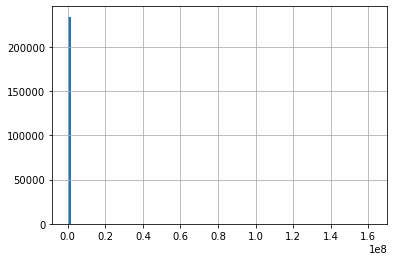

In [27]:
dataframe['deriv_credit'].hist(bins = 100)

In [33]:
dataframe['deriv_credit'].dropna().astype('int').describe()

count    2.339630e+05
mean     6.484175e+03
std      3.363578e+05
min     -7.500000e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.619910e+08
Name: deriv_credit, dtype: float64

- 75% 지점까지 0인것으로 보아, 절대 다수의 사례에선 total_credit과 credit의 차이가 없다.

- 다만, 음수인 사례와 1600만원이 넘어가는 사례에 대해서는 확인이 필요하다.

In [51]:
dataframe[dataframe['deriv_credit'] > 0]

id                       created_at  creator_id  \
27       81709 2019-05-27 06:05:23.631728+00:00       72218   
41       75413 2019-05-14 22:16:06.737204+00:00          44   
54       96487 2019-07-03 02:39:28.651629+00:00          62   
55      100181 2019-07-10 02:09:17.307076+00:00          99   
58       84937 2019-06-04 02:47:32.550868+00:00         120   
...        ...                              ...         ...   
233941  235116 2021-11-18 20:38:35.285817+00:00          44   
233943  235140 2021-11-18 21:16:54.667770+00:00          44   
233952  234794 2021-11-15 21:48:05.522708+00:00          44   
233954  235142 2021-11-18 21:16:54.667770+00:00          44   
233960  234918 2021-11-16 21:12:39.655984+00:00          44   

                             updated_at  updater_id use_yn  type  buyer_type  \
27     2019-05-27 07:48:08.874025+00:00       72218      Y   610         200   
41     2019-05-14 23:12:37.854146+00:00          44      N   610         200   
54     2019-07-05 06:25:55.121326+00:00         129      Y   610         200   
55     2019-07-15 08:11:14.187141+00:00         148      Y   610         100   
58     2019-06-04 06:30:31.708686+00:00         120      Y   610         200   
...                                 ...         ...    ...   ...         ...   
233941 2021-11-19 08:07:26.498422+00:00         194      Y   610         200   
233943 2021-11-18 21:16:54.667770+00:00          44      Y   610         200   
233952 2021-11-19 07:12:59.236454+00:00         194      Y   610         200   
233954 2021-11-19 07:47:08.966942+00:00         194      Y   610         200   
233960 2021-11-19 08:07:26.498422+00:00         194      Y   610         200   

        buyer_id  brand_id  order_id  order_product_id  \
27         72218      9062    391528           6439214   
41         27698      3472    381695           6249320   
54         34559       677    425739           7069444   
55         67281     10466    433009           7206318   
58         34559      8393    398762           6570733   
...          ...       ...       ...               ...   
233941     88487     11715   1173464          15978084   
233943     22020     17808   1171580          15962606   
233952    143387     17719   1167796          15923487   
233954     22020      6232   1172777          15972566   
233960     88487     16269   1171341          15959862   

        order_product_extra_id total_credit    credit  quantity used_credit  \
27                    262679.0     68000.00  34000.00         2    68000.00   
41                    251041.0     35000.00   7000.00         5        0.00   
54                    298072.0     14000.00   7000.00         2    14000.00   
55                         NaN    100000.00  20000.00         5   100000.00   
58                    271044.0     14000.00   7000.00         2    14000.00   
...                        ...          ...       ...       ...         ...   
233941                695307.0     22000.00  11000.00         2    17000.00   
233943                695085.0      7000.00   3500.00         2        0.00   
233952                694600.0     40000.00  20000.00         2    40000.00   
233954                695216.0     27000.00   9000.00         3    27000.00   
233960                694885.0     52000.00  26000.00         2    52000.00   

        status     memo wait_shipment_status  register_type  register_id  \
27         400     None                 None            300        72218   
41         200     불량반품                 None            200           44   
54         400  교환 건 차감                 None            100           62   
55         400     미송품절                 None            100           99   
58         400     None                 None            100          120   
...        ...      ...                  ...            ...          ...   
233941     300     불량반품                 None            200           44   
233943     200    색상오배송                 

#### 가설 1 : credit * quantity = total_credit일 것이다.

가설을 검정한다.

In [58]:
dataframe.loc[dataframe['deriv_credit'] > 0, "total_credit"] - (
    dataframe.loc[dataframe['deriv_credit'] > 0, "credit"] * (
    dataframe.loc[dataframe['deriv_credit'] > 0, "quantity"]))

27        0.00
41        0.00
54        0.00
55        0.00
58        0.00
          ... 
233941    0.00
233943    0.00
233952    0.00
233954    0.00
233960    0.00
Length: 43672, dtype: object

<AxesSubplot:>

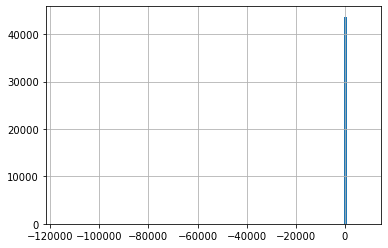

In [65]:
(dataframe.loc[dataframe['deriv_credit'] > 0, "total_credit"] - (
    dataframe.loc[dataframe['deriv_credit'] > 0, "credit"] * (
    dataframe.loc[dataframe['deriv_credit'] > 0, "quantity"]))).astype('int').hist(bins = 100)

In [66]:
(dataframe.loc[dataframe['deriv_credit'] > 0, "total_credit"] - (
    dataframe.loc[dataframe['deriv_credit'] > 0, "credit"] * (
    dataframe.loc[dataframe['deriv_credit'] > 0, "quantity"]))).astype('int').describe()

count     43672.000000
mean         -7.087012
std         733.836874
min     -115500.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        8500.000000
dtype: float64

소결론 : 대다수의 사례에서는 가설이 일치하나, 일부 사례에서 음수와 양수가 나왔다.

해당 데이터에 대한 확인을 실시한다.

In [89]:
dataframe[dataframe['deriv_credit'] > 0][(dataframe.loc[dataframe['deriv_credit'] > 0, "total_credit"] - (
    dataframe.loc[dataframe['deriv_credit'] > 0, "credit"] * (
    dataframe.loc[dataframe['deriv_credit'] > 0, "quantity"]))) > 0]

id                       created_at  creator_id  \
182759  196716 2020-11-09 03:08:00.816522+00:00          33   

                             updated_at  updater_id use_yn  type  buyer_type  \
182759 2020-11-09 08:06:35.536945+00:00         115      Y   610         200   

        buyer_id  brand_id  order_id  order_product_id  \
182759     48526      3455    869810          12936883   

        order_product_extra_id total_credit   credit  quantity used_credit  \
182759                616660.0     17000.00  8500.00         1        0.00   

        status         memo wait_shipment_status  register_type  register_id  \
182759     900  2장 중, 1장 반송                 None            100           33   

       uncle_memo deleted_memo seller_approval_credit  updater_type  \
182759       None  상태변경 (차감대기)               17000.00         300.0   

       deriv_credit  
182759      8500.00

In [85]:
dataframe[(dataframe['brand_id'] == 3455) & (
    dataframe['buyer_id'] == 48526)].sort_values(by = 'created_at').reset_index(drop = True)[230:250]

id                       created_at  creator_id  \
230  195583 2020-11-01 21:40:13.897635+00:00          44   
231  195893 2020-11-02 21:19:59.683072+00:00          44   
232  195894 2020-11-02 21:19:59.683072+00:00          44   
233  195892 2020-11-02 21:19:59.683072+00:00          44   
234  195891 2020-11-02 21:19:59.683072+00:00          44   
235  196000 2020-11-03 20:57:54.699645+00:00          44   
236  196096 2020-11-03 21:22:59.019181+00:00          44   
237  196384 2020-11-05 21:14:03.754346+00:00          44   
238  196716 2020-11-09 03:08:00.816522+00:00          33   
239  196720 2020-11-09 07:28:54.069078+00:00       48526   
240  196726 2020-11-09 08:03:55.072181+00:00         115   
241  196727 2020-11-09 08:04:41.912145+00:00         115   
242  196728 2020-11-09 08:05:22.823846+00:00         115   
243  197896 2020-11-17 20:57:56.079654+00:00         121   
244  198055 2020-11-18 20:28:51.826701+00:00         121   
245  198586 2020-11-23 07:15:51.499172+00:00       48526   
246  198587 2020-11-23 07:15:54.806002+00:00       48526   
247  198588 2020-11-23 07:15:57.188589+00:00       48526   
248  198589 2020-11-23 07:15:59.396750+00:00       48526   
249  198590 2020-11-23 07:16:01.463354+00:00       48526   

                          updated_at  updater_id use_yn  type  buyer_type  \
230 2020-11-09 07:39:52.931587+00:00         115      Y   610         200   
231 2020-11-23 07:15:35.557308+00:00       48526      Y   610         200   
232 2020-11-09 07:39:27.425916+00:00         115      Y   610         200   
233 2020-11-09 07:38:49.951419+00:00         115      Y   610         200   
234 2020-11-23 07:15:33.124705+00:00       48526      Y   610         200   
235 2020-11-03 21:22:59.019181+00:00          44      N   610         200   
236 2020-11-09 07:38:03.449110+00:00         115      Y   610         200   
237 2020-11-09 08:06:35.536945+00:00         115      Y   610         200   
238 2020-11-09 08:06:35.536945+00:00         115      Y   610         200   
239 2020-11-09 08:19:15.309778+00:00         129      Y   610         200   
240 2020-11-23 07:15:37.593370+00:00       48526      Y   610         200   
241 2020-11-23 07:15:39.876871+00:00       48526      Y   610         200   
242 2020-11-23 07:15:42.280492+00:00       48526      Y   610         200   
243 2020-11-19 08:53:04.579767+00:00         115      Y   610         200   
244 2020-11-23 07:15:44.320605+00:00       48526      Y   610         200   
245 2020-11-23 08:14:58.846892+00:00         148      Y   610         200   
246 2020-11-30 07:14:26.853305+00:00         129      Y   610         200   
247 2020-12-02 07:01:26.574891+00:00         129      Y   610         200   
248 2020-12-03 07:52:25.353266+00:00         129      Y   610         200   
249 2020-12-09 08:20:41.829902+00:00         129      Y   610         200   

     buyer_id  brand_id  order_id  order_product_id  order_product_extra_id  \
230     48526      3455    863952          12877301                614728.0   
231     48526      3455    866217          12901125                615089.0   
232     48526      3455    866217          12901124                615088.0   
233     48526      3455    866217          12901126                615090.0   
234     48526      3455    866217          12901127                615091.0   
235     48526      3455    867258          12910602                615383.0   
236     48526      3455    867258          12910602                615383.0   
237     48526      3455    869810          12936883                616660.0   
238     48526      3455    869810          12936883                616660.0   
239     48526      3455    869810          12936883                616660.0   
240     48526      3455    867258          12910602                615383.0   
241     48526      3455    866217          12901124                615088.0   
242     48526      3455    866217          12901126                615090.0   
243     48526      3455 

- index 238 : 메모에 두장 중 한장 반송이라고 나와있다. 

- 삼촌이 입력한 사례로(creator_type = 200), 손실수로 보인다.

In [88]:
dataframe[dataframe['deriv_credit'] > 0][(dataframe.loc[dataframe['deriv_credit'] > 0, "total_credit"] - (
    dataframe.loc[dataframe['deriv_credit'] > 0, "credit"] * (
    dataframe.loc[dataframe['deriv_credit'] > 0, "quantity"]))) < 0]

id                       created_at  creator_id  \
92956    21995 2018-10-21 21:33:08.279591+00:00          44   
158134   83925 2019-05-30 21:22:40.648539+00:00         124   
163261  159444 2019-12-29 20:57:50.056872+00:00          44   
190153   80070 2019-05-22 21:58:02.730370+00:00         124   
192119  198188 2020-11-19 20:43:18.023082+00:00         121   
207916  203000 2020-12-28 19:29:51.341208+00:00          44   
209208  203696 2020-11-17 10:38:02.360096+00:00         177   
209387  204071 2021-01-07 20:32:37.149162+00:00         121   
222785  205906 2021-01-24 20:23:38.025662+00:00          44   
229026  230649 2021-09-07 21:01:51.921308+00:00          44   

                             updated_at  updater_id use_yn  type  buyer_type  \
92956  2018-10-22 06:59:26.362469+00:00          44      Y   610         200   
158134 2019-12-18 21:10:46.938947+00:00         124      Y   610         200   
163261 2021-05-24 06:20:58.021260+00:00         130      Y   610         200   
190153 2019-09-23 07:56:56.912473+00:00         149      Y   610         200   
192119 2021-01-08 08:23:34.243142+00:00         129      Y   610         200   
207916 2021-03-31 08:52:48.052943+00:00         149      Y   610         200   
209208 2021-02-23 06:37:23.078808+00:00         149      Y   610         200   
209387 2021-03-22 05:34:46.239018+00:00         149      Y   610         200   
222785 2021-05-23 16:10:01.993041+00:00          21      Y   610         200   
229026 2021-09-08 01:20:52.625783+00:00         130      Y   610         200   

        buyer_id  brand_id  order_id  order_product_id  \
92956      48526     11746    224943           3783557   
158134     68576      9300    397587           6548512   
163261     60330      2180    484397           8132429   
190153     34500     10402    389196           6396953   
192119     88487     10953    873061          12968477   
207916     35037      8408    912435          13344165   
209208     48526     16583    881389          13050133   
209387     60330     17285    918849          13404543   
222785     34500     16053    930381          13516378   
229026     52048     12992   1102955          15327998   

        order_product_extra_id total_credit    credit  quantity used_credit  \
92956                 108972.0     45000.00  15000.00         5    45000.00   
158134                269398.0      5000.00   1666.67         3     5000.00   
163261                378349.0     19000.00  17000.00         2    19000.00   
190153                258965.0    113000.00  15000.00        10   113000.00   
192119                617713.0     20000.00  18000.00         2    20000.00   
207916                631134.0     17500.00   9500.00        14    17500.00   
209208                620710.0     35000.00  26000.00         2    35000.00   
209387                633791.0     56000.00   7000.00        20    56000.00   
222785                638310.0     10500.00   7000.00         2        0.00   
229026                685867.0    676364.00  84546.00         8        0.00   

        status                 memo wait_shipment_status  register_type  \
92956      400                 불량반품                 None            200   
158134     300                 불량반품                 None            200   
163261     400                 불량반품                 None            200   
190153     400                   불량                 None            200   
192119     400                   반품                 None            200   
207916     400                   반품                 None            200   
209208     400  2020-12-30 대기 -> 취소                 None            200   
209387     400                   반품                 None            200   
222785     200     오염(볼펜자국, 넥부분 오염)                 None            200   
229026     200                   반품                 None            200   

        register_id          uncle_memo  \
92956            44         3장차감 2장남음\n   
158134          

- 대다수의 사례는 입력 실수로 보인다.

- 일부 셀러가 직접 입력한 사례의 경우, credit에 상품 단가를 입력하고, total_credit은 임의로 매입금을 입력한 것으로 보인다.

#### 결론 : total_credit은 credit * quantity이며, 값이 일치하지 않는 경우는 입력 실수로 확인된다.


In [90]:
dataframe

id                       created_at  creator_id  \
0        84662 2019-06-03 21:44:13.064588+00:00          44   
1        97328 2019-07-04 22:07:32.247916+00:00         124   
2       132682 2019-10-13 21:52:09.257259+00:00          44   
3        84655 2019-06-03 21:44:13.064588+00:00          44   
4        84665 2019-06-03 21:44:13.064588+00:00          44   
...        ...                              ...         ...   
233959  235153 2021-11-18 21:30:45.173048+00:00          44   
233960  234918 2021-11-16 21:12:39.655984+00:00          44   
233961  234792 2021-11-15 21:48:05.522708+00:00          44   
233962  234793 2021-11-15 21:48:05.522708+00:00          44   
233963  235156 2021-11-19 17:49:17.180219+00:00         215   

                             updated_at  updater_id use_yn  type  buyer_type  \
0      2019-06-04 06:02:22.559170+00:00          44      Y   610         200   
1      2019-07-24 00:48:26.123611+00:00         129      Y   610         200   
2      2019-10-14 07:58:17.793245+00:00         149      Y   610         200   
3      2019-06-04 06:02:22.559170+00:00          44      Y   610         200   
4      2019-06-04 06:02:22.559170+00:00          44      Y   610         200   
...                                 ...         ...    ...   ...         ...   
233959 2021-11-19 07:50:34.538560+00:00         194      Y   610         100   
233960 2021-11-19 08:07:26.498422+00:00         194      Y   610         200   
233961 2021-11-19 08:07:26.498422+00:00         194      Y   610         200   
233962 2021-11-19 08:07:26.498422+00:00         194      Y   610         200   
233963 2021-11-19 17:49:17.180219+00:00         215      Y   610         200   

        buyer_id  brand_id  order_id  order_product_id  \
0           8489      8233    398626           6568026   
1          35811     14478    428093           7111659   
2           8489      6347    503013           8427250   
3           8489     12051    398626           6568023   
4           8489     12123    398626           6568032   
...          ...       ...       ...               ...   
233959    138543     15147   1154328          15795299   
233960     88487     16269   1171341          15959862   
233961     88487     18088   1168955          15936326   
233962     88487     18088   1168955          15936325   
233963     88487     15833   1173258          15976729   

        order_product_extra_id total_credit    credit  quantity used_credit  \
0                     270425.0      9000.00   9000.00         1     9000.00   
1                     300602.0      7000.00   7000.00         1     7000.00   
2                     400381.0     22000.00  22000.00         1    22000.00   
3                     270422.0      9000.00   9000.00         1     9000.00   
4                     270431.0     29000.00  29000.00         1    29000.00   
...                        ...          ...       ...       ...         ...   
233959                694545.0     27000.00  27000.00         1    27000.00   
233960                694885.0     52000.00  26000.00         2    52000.00   
233961                694664.0     10000.00  10000.00         1    10000.00   
233962                694663.0     10000.00  10000.00         1    10000.00   
233963                695131.0     14000.00  14000.00         1        0.00   

        status                 memo wait_shipment_status  register_type  \
0          400                 불량반품                 None            200   
1          400                   반품                 None            200   
2          400                 불량반품                 None            200   
3          400                 불량반품                 None            200   
4          400                 불량반품                 None            200   
...        ...                  ...                  ...            ...   
233959     400          [반품] 매장협의완료                 None            200   
233960     400                 불량반품             

#### - 

In [25]:
result_log_type = dataframe.groupby(['buyer_id', 'brand_id', 'credit']).apply(lambda x : list(x['log_type'])).reset_index()

In [26]:
result_log_type.apply(lambda x : x[0][0], axis = 1).value_counts()

100    2712
200      23
300      11
500       2
dtype: int64

log_type의 경우, 첫 번째는 역시 '최초 생성(100)'으로 시작하는 경우가 많았다.

첫번째가 '승인금액변경', '매입차감', '상태변경'인 경우도 소수나마 존재하긴 한다.

In [96]:
dataframe

id                       created_at  creator_id use_yn  buyer_id  \
0        1 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
1        2 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
2        3 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
3        4 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
4        5 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
...    ...                              ...         ...    ...       ...   
6102  6103 2021-11-16 21:12:39.655984+00:00          44      Y     52048   
6103  6104 2021-11-17 08:42:28.406188+00:00         194      Y     52048   
6104  6105 2021-11-19 10:45:04.483768+00:00         193      Y     22020   
6105  6106 2021-11-19 10:56:25.597858+00:00         193      Y     22020   
6106  6107 2021-11-19 10:57:05.296935+00:00         193      Y     22020   

      brand_id     credit used_credit  status  \
0         8538    7000.00     7000.00     400   
1         7963   10000.00    10000.00     400   
2         9124   15000.00    15000.00     400   
3        12882    6000.00        0.00     200   
4         6499   69000.00    69000.00     400   
...        ...        ...         ...     ...   
6102     16241  136000.00    30000.00     300   
6103     16241  136000.00   136000.00     400   
6104     16638    2000.00        0.00     200   
6105     16638    2000.00        0.00     900   
6106     16638    2000.00        0.00     200   

                                     memo refund_vat deleted_memo  \
0       169652/#아띠랑스/마 3부 점프 슈트/네이비/누락 품절     700.00         None   
1             168425/#ELSI/단가라니트OPS /누락품절    1000.00         None   
2               159942/#더밍샵/모먼핏 원피스/교환환불건    1500.00         None   
3      매입일자:18-03-26 / 바이어명 : 백련 / 단추블라우스     600.00         None   
4     매입일자:18-02-20 / 바이어명 : 커먼페럴 / 호피퍼CT    6900.00         None   
...                                   ...        ...          ...   
6102                               매장확인완료   13600.00         None   
6103                               매장확인완료   13600.00         None   
6104                                  과입금     200.00         None   
6105                                  과입금     200.00        사유미기재   
6106                               과입금차액건     200.00         None   

     seller_approval_credit  credit_buyer_id  platform  creator_type  \
0                   7000.00              263       100           100   
1                  10000.00              264       100           100   
2                  15000.00              256       100           100   
3                      0.00              155       100           100   
4                  69000.00              198       100           100   
...                     ...              ...       ...           ...   
6102              136000.00             2935       101           200   
6103              136000.00             2935       100           100   
6104                2000.00             2937       100           100   
6105                2000.00             2937       100           100   
6106                2000.00             2938       100           100   

      log_type  buyer_type deriv_credit  
0          100         100         0.00  
1          100         100         0.00  
2          100         100         0.00  
3          100         100      6000.00  
4          100         100         0.00  
...        ...         ...          ...  
6102       200         200    106000.00  
6103       300         200         0.00  
6104       100         200      2000.00  
6105       500         200      2000.00  
6106       100         200      2000.00  

[6107 rows x 19 columns]

In [27]:
result_status = dataframe.groupby(['buyer_id', 'brand_id', 'credit']).apply(lambda x : list(x['status'])).reset_index()

In [28]:
result_deriv_credit = dataframe.groupby(['buyer_id', 'brand_id', 'credit']).apply(lambda x : list(x['deriv_credit'])).reset_index()

In [29]:
result_status

buyer_id  brand_id     credit  \
0         5064      5063  107000.00   
1         5064      5111   32000.00   
2         5064      5553    1000.00   
3         5064      5615   16000.00   
4         5064      5664   10000.00   
...        ...       ...        ...   
2743    143387     17351   22000.00   
2744    143387     17351  144800.00   
2745    143387     17413   23000.00   
2746    143387     17413  115000.00   
2747    143387     17413  156000.00   

                                                      0  
0                                                 [200]  
1                                                 [400]  
2                                                 [400]  
3                                                 [400]  
4                                                 [400]  
...                                                 ...  
2743                                         [200, 400]  
2744  [200, 200, 200, 300, 300, 300, 300, 300, 300, ...  
2745                                         [200, 400]  
2746  [300, 300, 300, 300, 300, 300, 300, 300, 300, ...  
2747                                    [200, 200, 300]  

[2748 rows x 4 columns]

In [30]:
result_deriv_credit

buyer_id  brand_id     credit  \
0         5064      5063  107000.00   
1         5064      5111   32000.00   
2         5064      5553    1000.00   
3         5064      5615   16000.00   
4         5064      5664   10000.00   
...        ...       ...        ...   
2743    143387     17351   22000.00   
2744    143387     17351  144800.00   
2745    143387     17413   23000.00   
2746    143387     17413  115000.00   
2747    143387     17413  156000.00   

                                                      0  
0                                           [107000.00]  
1                                                [0.00]  
2                                                [0.00]  
3                                                [0.00]  
4                                                [0.00]  
...                                                 ...  
2743                                   [22000.00, 0.00]  
2744  [144800.00, 144800.00, 144800.00, 56800.00, 56...  
2745                                   [23000.00, 0.00]  
2746  [96000.00, 79000.00, 79000.00, 65000.00, 65000...  
2747                  [156000.00, 156000.00, 137000.00]  

[2748 rows x 4 columns]

In [31]:
result_merged = pd.merge(
         pd.merge(
                  result_log_type, 
                  result_status, 
                  on = ['buyer_id', 'brand_id', 'credit']), 
         result_deriv_credit, 
         on = ['buyer_id','brand_id','credit'])

In [32]:
result_merged.columns = ['buyer_id','brand_id','credit', 'log_type','status','deriv_credit']

#### - 각 브랜드ID / 바이어ID / 매입액 별 첫번째 log_type과 status

In [110]:
result_merged['log_type_status'].apply(lambda x : x[0]).value_counts()

100-200    1576
100-400    1111
100-300      25
200-200      15
200-300       8
300-400       7
300-300       4
500-900       2
Name: log_type_status, dtype: int64

- 100 - 200과 100 - 400은 신규 생성 - 차감승인/차감완료 사례라 타당한 것으로 보인다.

- 문제는 그 외의 사례들이다.

- 나머지 사례들이 어떤 경우인지 확인이 필요하다.

In [119]:
dataframe[dataframe['brand_id'] == 10687]

id                       created_at  creator_id use_yn  buyer_id  \
1098  1099 2019-05-14 11:38:38.135827+00:00           1      Y     35037   
4485  4250 2020-01-08 06:43:55.267030+00:00         115      Y     60330   
4488  4253 2020-01-08 07:16:41.058832+00:00         148      Y     60330   
5864  5865 2021-09-02 07:21:46.145006+00:00         189      Y    143387   
5868  5869 2021-09-02 07:41:31.852645+00:00         130      Y    143387   
5881  5882 2021-09-02 21:36:15.684248+00:00          44      Y    143387   
5885  5886 2021-09-03 06:34:57.205224+00:00         148      Y    143387   
5916  5917 2021-09-07 21:01:51.921308+00:00          44      Y    143387   
5922  5923 2021-09-08 07:45:57.757441+00:00         130      Y    143387   
5929  5930 2021-09-08 08:26:50.993097+00:00         148      Y    143387   
5930  5931 2021-09-08 08:26:50.993097+00:00         148      Y    143387   
5937  5938 2021-09-08 20:43:28.191891+00:00          44      Y    143387   
5940  5941 2021-09-08 20:57:52.740643+00:00          44      Y    143387   
5945  5946 2021-09-09 07:45:37.532133+00:00         148      Y    143387   
5951  5952 2021-09-09 21:08:43.440753+00:00          44      Y    143387   
5954  5955 2021-09-09 21:51:07.628826+00:00          44      Y    143387   
5955  5956 2021-09-10 05:09:06.452111+00:00         148      Y    143387   

      brand_id    credit used_credit  status  \
1098     10687  21000.00    21000.00     400   
4485     10687  11000.00        0.00     200   
4488     10687  11000.00    11000.00     400   
5864     10687  52200.00        0.00     200   
5868     10687  52200.00        0.00     200   
5881     10687  52200.00        0.00     200   
5885     10687  52200.00     7000.00     300   
5916     10687  45200.00     7000.00     300   
5922     10687  45200.00    16600.00     300   
5929     10687  45200.00     7000.00     300   
5930     10687  45200.00    16600.00     300   
5937     10687  45200.00    16600.00     300   
5940     10687  45200.00    16600.00     300   
5945     10687  45200.00    41500.00     300   
5951     10687  45200.00    41500.00     300   
5954     10687  45200.00    41500.00     300   
5955     10687  45200.00    45200.00     400   

                                                   memo refund_vat  \
1098                                           1/14 장끼건    2100.00   
4485  E-8800 히든슬렉스(8800 히든 밴딩 슬랙스) / [라이트그레이-2XL(36)...    1100.00   
4488  E-8800 히든슬렉스(8800 히든 밴딩 슬랙스) / [라이트그레이-2XL(36)...    1100.00   
5864                                              남은매입금    5220.00   
5868                                              남은매입금    5220.00   
5881                                              남은매입금    5220.00   
5885                                              남은매입금    5220.00   
5916                                              남은매입금    4520.00   
5922                                              남은매입금    4520.00   
5929                                              남은매입금    4520.00   
5930                                              남은매입금    4520.00   
5937                                              남은매입금    4520.00   
5940                                              남은매입금    4520.00   
5945                                              남은매입금    4520.00   
5951                                              남은매입금    4520.00   
5954                                              남은매입금    4520.00   
5955                                              남은매입금    4520.00   

     deleted_memo seller_approval_credit  credit_buyer_id  platform  \
1098         None               21000.00             1062       100   
4485         None               11000.00             2437       100   
4488         None               11000.00             2437       100   
5864         None               52200.00             2899       100   
5868         None                   0.00             2899       100   
5881         None                7000.00             2899       101   
5885         Non

In [118]:
result_merged[result_merged['brand_id'] == 	10687]

buyer_id  brand_id    credit  \
725      35037     10687  21000.00   
1571     60330     10687  11000.00   
2711    143387     10687  45200.00   
2712    143387     10687  52200.00   

                                               log_type  \
725                                               [100]   
1571                                         [100, 300]   
2711  [200, 300, 400, 300, 200, 200, 300, 200, 200, ...   
2712                               [100, 200, 200, 300]   

                                                 status  \
725                                               [400]   
1571                                         [200, 400]   
2711  [300, 300, 300, 300, 300, 300, 300, 300, 300, ...   
2712                               [200, 200, 200, 300]   

                                           deriv_credit  \
725                                              [0.00]   
1571                                   [11000.00, 0.00]   
2711  [38200.00, 28600.00, 38200.00, 28600.00, 28600...   
2712           [52200.00, 52200.00, 52200.00, 45200.00]   

                                        log_type_status  \
725                                           [100-400]   
1571                                 [100-200, 300-400]   
2711  [200-300, 300-300, 400-300, 300-300, 200-300, ...   
2712               [100-200, 200-200, 200-200, 300-300]   

                                      diff_deriv_credit  \
725                                                  []   
1571                                        [-11000.00]   
2711  [-9600.00, 9600.00, -9600.00, 0.00, 0.00, -249...   
2712                             [0.00, 0.00, -7000.00]   

                                  diff_deriv_credit_neg  
725                                                  []  
1571                                             [True]  
2711  [True, False, True, False, False, True, False,...  
2712                               [False, False, True]

In [117]:
result_merged[result_merged['log_type_status'].apply(lambda x : x[0] not in ['100-200', '100-400'])]

buyer_id  brand_id     credit  \
11        6796      9124  200000.00   
48        8525      4531   34000.00   
81        8525      6619   38000.00   
91        8525      7739   37400.00   
113       8525      8444   25000.00   
...        ...       ...        ...   
2622     88487     11067   72000.00   
2665     88487     15821    4500.00   
2705    143387      5692   52000.00   
2711    143387     10687   45200.00   
2746    143387     17413  115000.00   

                                               log_type  \
11    [300, 300, 300, 200, 300, 200, 300, 300, 300, ...   
48                                                [100]   
81                                                [100]   
91                                                [100]   
113                                               [100]   
...                                                 ...   
2622                     [200, 300, 100, 300, 200, 300]   
2665                                         [300, 100]   
2705                               [200, 300, 200, 300]   
2711  [200, 300, 400, 300, 200, 200, 300, 200, 200, ...   
2746  [200, 300, 200, 300, 200, 300, 400, 300, 200, ...   

                                                 status  \
11    [300, 300, 300, 300, 300, 300, 300, 300, 300, ...   
48                                                [300]   
81                                                [300]   
91                                                [300]   
113                                               [300]   
...                                                 ...   
2622                     [300, 400, 200, 300, 300, 300]   
2665                                         [400, 200]   
2705                               [300, 300, 300, 400]   
2711  [300, 300, 300, 300, 300, 300, 300, 300, 300, ...   
2746  [300, 300, 300, 300, 300, 300, 300, 300, 300, ...   

                                           deriv_credit  \
11    [159000.00, 133000.00, 103000.00, 106000.00, 7...   
48                                           [12000.00]   
81                                            [9000.00]   
91                                            [9400.00]   
113                                           [6000.00]   
...                                                 ...   
2622  [11000.00, 0.00, 72000.00, 42000.00, 42000.00,...   
2665                                    [0.00, 4500.00]   
2705               [40000.00, 20000.00, 20000.00, 0.00]   
2711  [38200.00, 28600.00, 38200.00, 28600.00, 28600...   
2746  [96000.00, 79000.00, 79000.00, 65000.00, 65000...   

                                        log_type_status  \
11    [300-300, 300-300, 300-300, 200-300, 300-300, ...   
48                                            [100-300]   
81                                            [100-300]   
91                                            [100-300]   
113                                           [100-300]   
...                                                 ...   
2622  [200-300, 300-400, 100-200, 300-300, 200-300, ...   
2665                                 [300-400, 100-200]   
2705               [200-300, 300-300, 200-300, 300-400]   
2711  [200-300, 300-300, 400-300, 300-300, 200-300, ...   
2746  [200-300, 300-300, 200-300, 300-300, 200-300, ...   

                                      diff_deriv_credit  \
11    [-26000.00, -30000.00, 3000.00, -28000.00, 0.0...   
48                                                   []   
81                                                   []   
91                                                   []   
113                                                  []   
...                                                 ...   
2622  [-11000.00, 72000.00, -30000.00, 0.00, -31000.00]   
2665                                          [4500.00]   
2705                       [-20000.00, 0.00, -20000.00]   
2711  [-9600.00, 9600.00, -9600.00, 0.00, 0.00, -249...   
2746  [-17000.00, 0.00, -14000.00, 0.00, -23000.00, 

#### - 실제 금액 차감이 이루어졌을 때 log_type과 status

In [116]:
def string_concater(x1, x2):
    new_list = list()
    for y1, y2 in zip(x1, x2):
        new_list.append(str(y1) + '-' + str(y2))
    return new_list

In [100]:
result_merged['log_type_status'] = result_merged.apply(lambda x : string_concater(x['log_type'],x['status']), axis = 1)

In [101]:
result_merged['diff_deriv_credit'] = result_merged.apply(lambda x : np.diff(x['deriv_credit']), axis = 1)

In [102]:
result_merged['diff_deriv_credit_neg'] = result_merged[result_merged['log_type_status'].apply(
    lambda x : len(x)) > 0]['diff_deriv_credit'].apply(lambda x : np.array(x) < 0)

In [103]:
log_type_status = result_merged[result_merged['log_type_status'].apply(lambda x : len(x)) > 0].apply(
    lambda x : np.unique(np.array(x['log_type_status'][1:])[x['diff_deriv_credit_neg']]), axis = 1)

잔액 매입금 차감이 이루어졌을 때의 log_type과 status의 빈도표는 아래와 같다.

In [104]:
log_type_status.apply(lambda x : pd.Series(x).value_counts()).sum()

100-400     22.0
200-300      6.0
300-300    262.0
300-400    930.0
dtype: float64

300-300과 300-400은 매입 차감 - 부분차감/차감완료 부분이라 이해가 가능하다.

그런데, 200-300과 100-400은 승인금액변경 - 부분차감과 최초생성 - 차감완료라 확인이 필요하다.

In [39]:
result_merged[result_merged['log_type_status'].apply(lambda x : len(x)) > 0][log_type_status.apply(lambda x : '100-400' in x)]

buyer_id  brand_id     credit              log_type  \
83        8525      6745   30000.00            [100, 100]   
407      34500     10187   10000.00            [100, 100]   
569      34559     11710  100000.00            [100, 100]   
720      35037     10353    1000.00            [100, 100]   
909      39779      5519     500.00            [100, 100]   
1030     39779     10962    1000.00            [100, 100]   
1047     39779     11615    1000.00  [100, 100, 100, 100]   
1113     45065      7209   45000.00            [100, 100]   
1167     46505      2094   12000.00            [100, 100]   
1219     46505      7806   22000.00            [100, 100]   
1263     46505     10901    2000.00            [100, 100]   
1403     48526     11486   39000.00            [100, 100]   
1453     52048     11643   89000.00            [100, 100]   
1690     61663      8634   65000.00       [100, 100, 100]   
1711     61663     12569   60000.00            [100, 100]   
1770     61910      5345   48000.00            [100, 100]   
1773     61910      5568    2000.00            [100, 100]   
1774     61910      5568   23000.00            [100, 100]   
1815     63480      5139   52000.00            [100, 100]   
1816     63480      5557   18000.00            [100, 100]   
1839     64730     10586   19000.00       [100, 100, 100]   
2210     72218     13505   35000.00            [100, 100]   

                    status                 deriv_credit  \
83              [200, 400]             [30000.00, 0.00]   
407             [200, 400]             [10000.00, 0.00]   
569             [200, 400]            [100000.00, 0.00]   
720             [200, 400]              [1000.00, 0.00]   
909             [200, 400]               [500.00, 0.00]   
1030            [200, 400]              [1000.00, 0.00]   
1047  [400, 200, 400, 400]  [0.00, 1000.00, 0.00, 0.00]   
1113            [200, 400]             [45000.00, 0.00]   
1167            [200, 400]             [12000.00, 0.00]   
1219            [200, 400]             [22000.00, 0.00]   
1263            [200, 400]              [2000.00, 0.00]   
1403            [200, 400]             [39000.00, 0.00]   
1453            [200, 400]             [89000.00, 0.00]   
1690       [200, 200, 400]   [65000.00, 65000.00, 0.00]   
1711            [200, 400]             [60000.00, 0.00]   
1770            [200, 400]             [48000.00, 0.00]   
1773            [200, 400]              [2000.00, 0.00]   
1774            [200, 400]             [23000.00, 0.00]   
1815            [200, 400]             [52000.00, 0.00]   
1816            [200, 400]             [18000.00, 0.00]   
1839       [400, 200, 400]       [0.00, 19000.00, 0.00]   
2210            [200, 400]             [35000.00, 0.00]   

                  log_type_status          diff_deriv_credit  \
83                      [100-400]                [-30000.00]   
407                     [100-400]                [-10000.00]   
569                     [100-400]               [-100000.00]   
720                     [100-400]                 [-1000.00]   
909                     [100-400]                  [-500.00]   
1030                    [100-400]                 [-1000.00]   
1047  [100-200, 100-400, 100-400]  [1000.00, -1000.00, 0.00]   
1113                    [100-400]                [-45000.00]   
1167                    [100-400]                [-12000.00]   
1219                    [100-400]                [-22000.00]   
1263                    [100-400]                 [-2000.00]   
1403                    [100-400]                [-39000.00]   
1453                    [100-400]                [-89000.00]   
1690           [100-200, 100-400]          [0.00, -65000.00]   
1711                    [100-400]                [-60000.00]   
1770                    [100-400]                [-48000.00]   
1773                    [100-400]                 [-2000.00]   
1774                    [100-400]                [-23000.00]   
1815                    [100

In [40]:
result_merged[result_merged['log_type_status'].apply(lambda x : len(x)) > 0][log_type_status.apply(lambda x : '200-300' in x)]

buyer_id  brand_id     credit  \
11        6796      9124  200000.00   
336      33285      3377  198000.00   
1806     62561      7796   54000.00   
2594     88487      7709  118000.00   
2635     88487     12062   26000.00   
2655     88487     14286   64000.00   

                                               log_type  \
11    [300, 300, 300, 200, 300, 200, 300, 300, 300, ...   
336                           [200, 300, 100, 200, 300]   
1806  [100, 200, 200, 300, 200, 300, 200, 300, 400, ...   
2594                                    [100, 200, 300]   
2635                                    [100, 200, 300]   
2655                                    [100, 200, 300]   

                                                 status  \
11    [300, 300, 300, 300, 300, 300, 300, 300, 300, ...   
336                           [200, 300, 200, 300, 400]   
1806  [200, 300, 300, 400, 200, 300, 300, 300, 300, ...   
2594                                    [200, 300, 400]   
2635                                    [200, 300, 400]   
2655                                    [200, 300, 400]   

                                           deriv_credit  \
11    [159000.00, 133000.00, 103000.00, 106000.00, 7...   
336    [198000.00, 16000.00, 198000.00, 16000.00, 0.00]   
1806  [54000.00, 16000.00, 16000.00, 0.00, 54000.00,...   
2594                        [118000.00, 35000.00, 0.00]   
2635                         [26000.00, 14000.00, 0.00]   
2655                         [64000.00, 48000.00, 0.00]   

                                        log_type_status  \
11    [300-300, 300-300, 200-300, 300-300, 200-300, ...   
336                [300-300, 100-200, 200-300, 300-400]   
1806  [200-300, 200-300, 300-400, 200-200, 300-300, ...   
2594                                 [200-300, 300-400]   
2635                                 [200-300, 300-400]   
2655                                 [200-300, 300-400]   

                                      diff_deriv_credit  \
11    [-26000.00, -30000.00, 3000.00, -28000.00, 0.0...   
336      [-182000.00, 182000.00, -182000.00, -16000.00]   
1806  [-38000.00, 0.00, -16000.00, 54000.00, -7000.0...   
2594                             [-83000.00, -35000.00]   
2635                             [-12000.00, -14000.00]   
2655                             [-16000.00, -48000.00]   

                                  diff_deriv_credit_neg  
11    [True, True, False, True, False, True, True, F...  
336                           [True, False, True, True]  
1806  [True, False, True, False, True, False, True, ...  
2594                                       [True, True]  
2635                                       [True, True]  
2655                                       [True, True]

In [95]:
result_merged[result_merged['brand_id'] == 7796]['deriv_credit'].tolist()

[[Decimal('54000.00'),
  Decimal('16000.00'),
  Decimal('16000.00'),
  Decimal('0.00'),
  Decimal('54000.00'),
  Decimal('47000.00'),
  Decimal('47000.00'),
  Decimal('21000.00'),
  Decimal('47000.00'),
  Decimal('21000.00'),
  Decimal('47000.00'),
  Decimal('21000.00'),
  Decimal('21000.00'),
  Decimal('16000.00'),
  Decimal('21000.00'),
  Decimal('16000.00')]]

In [98]:
DataFrame({'1' : result_merged[result_merged['brand_id'] == 7796]['log_type_status'].tolist()[0],
           '2' : result_merged[result_merged['brand_id'] == 7796]['diff_deriv_credit'].tolist()[0],
           '3' : result_merged[result_merged['brand_id'] == 7796]['deriv_credit'].tolist()[0][1:]})

1          2         3
0   200-300  -38000.00  16000.00
1   200-300       0.00  16000.00
2   300-400  -16000.00      0.00
3   200-200   54000.00  54000.00
4   300-300   -7000.00  47000.00
5   200-300       0.00  47000.00
6   300-300  -26000.00  21000.00
7   400-300   26000.00  47000.00
8   300-300  -26000.00  21000.00
9   400-300   26000.00  47000.00
10  300-300  -26000.00  21000.00
11  200-300       0.00  21000.00
12  300-300   -5000.00  16000.00
13  400-300    5000.00  21000.00
14  300-300   -5000.00  16000.00